# Recurrent Neural Network from Scratch

This exercise was realised following the following tutorials: <br>
1. [Josh Varty](http://joshvarty.github.io/VisualizingRNNs/?fbclid=IwAR3bRODKxKeV03Nmu-VxL_Oy1-bLKYl-dunFsUVbWVGsI-baFEFzoAOe0UY) <br>
2. [Javaid Nabi](https://towardsdatascience.com/recurrent-neural-networks-rnns-3f06d7653a85)
3. [FAIZAN SHAIKH](https://www.analyticsvidhya.com/blog/2019/01/fundamentals-deep-learning-recurrent-neural-networks-scratch-python/)

## Creating the model

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def rnn(X, Y, nepoch=25, learning_rate=0.0001, T=50, hidden_dim=100, 
        output_dim =1):

    bptt_truncate = 5
    min_clip_value = -10
    max_clip_value = 10
    
    # Network weights
    # U = weight matrix between input and hidden layer
    # V = weight matrix between input and output layer
    # W = weight matrix for the shared weights in the hidden layer
    U = np.random.uniform(0, 1, (hidden_dim, T))
    W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
    V = np.random.uniform(0, 1, (output_dim, hidden_dim))
    
#     Step 2.1 : Check the loss on training data
#     Step 2.1.1 : Forward Pass
#     Step 2.1.2 : Calculate Error
#     Step 2.2 : Check the loss on validation data
#     Step 2.2.1 : Forward Pass
#     Step 2.2.2 : Calculate Error
#     Step 2.3 : Start actual training
#     Step 2.3.1 : Forward Pass
#     Step 2.3.2 : Backpropagate Error
#     Step 2.3.3 : Update weights

    for epoch in range(nepoch):
        # check loss on train
        loss = 0.0

        # do a forward pass to get prediction
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]                    
            # get input, output values of each record
            prev_s = np.zeros((hidden_dim, 1))   
            # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
            for t in range(T):
                new_input = np.zeros(x.shape)    
                # we then do a forward pass for every timestep in the sequence
                new_input[t] = x[t]              
                # for this, we define a single input for that timestep
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                s = sigmoid(add)
                mulv = np.dot(V, s)
                prev_s = s

            # calculate error 
            loss_per_record = (y - mulv)**2 / 2
            loss += loss_per_record
        loss = loss / float(y.shape[0])

        # check loss on val
        val_loss = 0.0
        for i in range(Y_val.shape[0]):
            x, y = X_val[i], Y_val[i]
            prev_s = np.zeros((hidden_dim, 1))
            for t in range(T):
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                s = sigmoid(add)
                mulv = np.dot(V, s)
                prev_s = s

            loss_per_record = (y - mulv)**2 / 2
            val_loss += loss_per_record
        val_loss = val_loss / float(y.shape[0])

        print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

        # train model
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]

            layers = []
            prev_s = np.zeros((hidden_dim, 1))
            dU = np.zeros(U.shape)
            dV = np.zeros(V.shape)
            dW = np.zeros(W.shape)

            dU_t = np.zeros(U.shape)
            dV_t = np.zeros(V.shape)
            dW_t = np.zeros(W.shape)

            dU_i = np.zeros(U.shape)
            dW_i = np.zeros(W.shape)

            # forward pass
            for t in range(T):
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                mulu = np.dot(U, new_input)
                mulw = np.dot(W, prev_s)
                add = mulw + mulu
                s = sigmoid(add)
                mulv = np.dot(V, s)
                layers.append({'s':s, 'prev_s':prev_s})
                prev_s = s

            # derivative of pred
            dmulv = (mulv - y)

            # backward pass
            for t in range(T):
                dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
                dsv = np.dot(np.transpose(V), dmulv)

                ds = dsv
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)

                dprev_s = np.dot(np.transpose(W), dmulw)


                for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                    ds = dsv + dprev_s
                    dadd = add * (1 - add) * ds

                    dmulw = dadd * np.ones_like(mulw)
                    dmulu = dadd * np.ones_like(mulu)

                    dW_i = np.dot(W, layers[t]['prev_s'])
                    dprev_s = np.dot(np.transpose(W), dmulw)

                    new_input = np.zeros(x.shape)
                    new_input[t] = x[t]
                    dU_i = np.dot(U, new_input)
                    dx = np.dot(np.transpose(U), dmulu)

                    dU_t += dU_i
                    dW_t += dW_i

                dV += dV_t
                dU += dU_t
                dW += dW_t

                # keeping the gradients in a range to avoid the they
                # expload/vanish
                if dU.max() > max_clip_value:
                    dU[dU > max_clip_value] = max_clip_value
                if dV.max() > max_clip_value:
                    dV[dV > max_clip_value] = max_clip_value
                if dW.max() > max_clip_value:
                    dW[dW > max_clip_value] = max_clip_value


                if dU.min() < min_clip_value:
                    dU[dU < min_clip_value] = min_clip_value
                if dV.min() < min_clip_value:
                    dV[dV < min_clip_value] = min_clip_value
                if dW.min() < min_clip_value:
                    dW[dW < min_clip_value] = min_clip_value

            # update
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
    return U, V, W, T, hidden_dim

In [4]:
# Function to make predictions using a trained RNN model
def rnn_pred(X,Y, U, V, W, T, hidden_dim):
    preds = []
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_s = np.zeros((hidden_dim, 1))
        # Forward pass
        for t in range(T):
            mulu = np.dot(U, x)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        preds.append(mulv)

    preds = np.array(preds)
    return preds

## Creating a toy dataset

Text(0.5, 1.0, 'Toy Dataset for RNN')

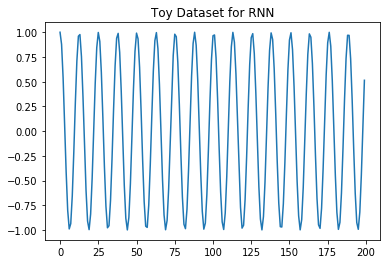

In [5]:
wave = np.array([math.cos(x/2) for x in np.arange(200)])
plt.plot(wave)
plt.title("Toy Dataset for RNN")

In [6]:
# Dividing the time series in training and test set and successively 
# preprocess it so that to have the right shape to fed in the RNN.
X = []
Y = []

T = seq_len = 30
num_records = len(wave) - seq_len

for i in range(num_records - 70):
    X.append(wave[i:i+seq_len])
    Y.append(wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

X_val = []
Y_val = []

for i in range(num_records - 70, num_records):
    X_val.append(wave[i:i+seq_len])
    Y_val.append(wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

print("Training set: ", X.shape, Y.shape)
print("Test set: ", X_val.shape, Y_val.shape)

Training set:  (100, 30, 1) (100, 1)
Test set:  (70, 30, 1) (70, 1)


## Testing the model

In [7]:
trained_model = rnn(X, Y, nepoch=20, learning_rate=0.0003, T=30, 
                    hidden_dim=150, output_dim =1)

Epoch:  1 , Loss:  [[267568.83916199]] , Val Loss:  [[187553.77471709]]
Epoch:  2 , Loss:  [[39645.2934236]] , Val Loss:  [[27849.97508706]]
Epoch:  3 , Loss:  [[23.14191545]] , Val Loss:  [[16.99516915]]
Epoch:  4 , Loss:  [[26.88050037]] , Val Loss:  [[19.85245302]]
Epoch:  5 , Loss:  [[34.45299611]] , Val Loss:  [[25.6077617]]
Epoch:  6 , Loss:  [[38.39925638]] , Val Loss:  [[28.55022864]]
Epoch:  7 , Loss:  [[37.08255783]] , Val Loss:  [[27.56718351]]
Epoch:  8 , Loss:  [[38.81414514]] , Val Loss:  [[28.85522333]]
Epoch:  9 , Loss:  [[40.48386604]] , Val Loss:  [[30.0928319]]
Epoch:  10 , Loss:  [[40.69354137]] , Val Loss:  [[30.25076984]]
Epoch:  11 , Loss:  [[41.46591211]] , Val Loss:  [[30.82421703]]
Epoch:  12 , Loss:  [[40.2180188]] , Val Loss:  [[29.9022533]]
Epoch:  13 , Loss:  [[40.16205617]] , Val Loss:  [[29.86315842]]
Epoch:  14 , Loss:  [[40.91615993]] , Val Loss:  [[30.42512827]]
Epoch:  15 , Loss:  [[38.60609967]] , Val Loss:  [[28.71666426]]
Epoch:  16 , Loss:  [[40.

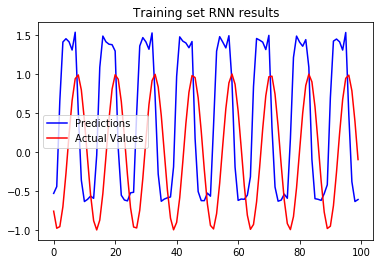

In [8]:
U, V, W, T, hidden_dim = trained_model
train_pre = rnn_pred(X, Y, U, V, W, T, hidden_dim)

plt.plot(train_pre[:, 0, 0], 'b', label="Predictions")
plt.plot(Y[:, 0], 'r', label="Actual Values")
plt.legend(loc="best")
plt.title("Training set RNN results")
plt.show()

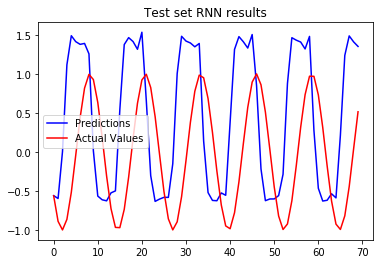

In [9]:
val_pre = rnn_pred(X_val, Y_val, U, V, W, T, hidden_dim)
    
preds = np.array(val_pre)

plt.plot(preds[:,0,0], 'b', label="Predictions")
plt.plot(Y_val[:,0], 'r', label="Actual Values")
plt.legend(loc="best")
plt.title("Test set RNN results")
plt.show()

In [10]:
math.sqrt(mean_squared_error(Y_val[:,0], preds[:,0,0]))

1.1307562094674943